In [22]:
import pandas as pd
import numpy as np
import darts
from darts.models.forecasting.arima import ARIMA
from darts import TimeSeries
import matplotlib.pyplot as plt

# loading Data

In [5]:
df = pd.read_csv('../ProcessedData/United States.csv')
df

,Country,Fiscal Year,Fiscal Week,Global DGV NS Visits,year,week_number,date
0,United States,2019-FY,2019-W01,1170974,2019,1,2019-01-07
1,United States,2019-FY,2019-W02,1178535,2019,2,2019-01-14
2,United States,2019-FY,2019-W03,1199019,2019,3,2019-01-21
3,United States,2019-FY,2019-W04,1136948,2019,4,2019-01-28
4,United States,2019-FY,2019-W05,1134891,2019,5,2019-02-04
...,...,...,...,...,...,...,...
283,United States,2024-FY,2024-W23,1014805,2024,23,2024-06-10
284,United States,2024-FY,2024-W24,945077,2024,24,2024-06-17
285,United States,2024-FY,2024-W25,909239,2024,25,2024-06-24
286,United States,2024-FY,2024-W26,886430,2024,26,2024-07-01


In [23]:
series = TimeSeries.from_dataframe(df, "date", "Global DGV NS Visits")
split_point = pd.Timestamp('2024-01-01')

train_series , test_series = series.split_after(split_point)


# Spliting Data into Training & Testing Data

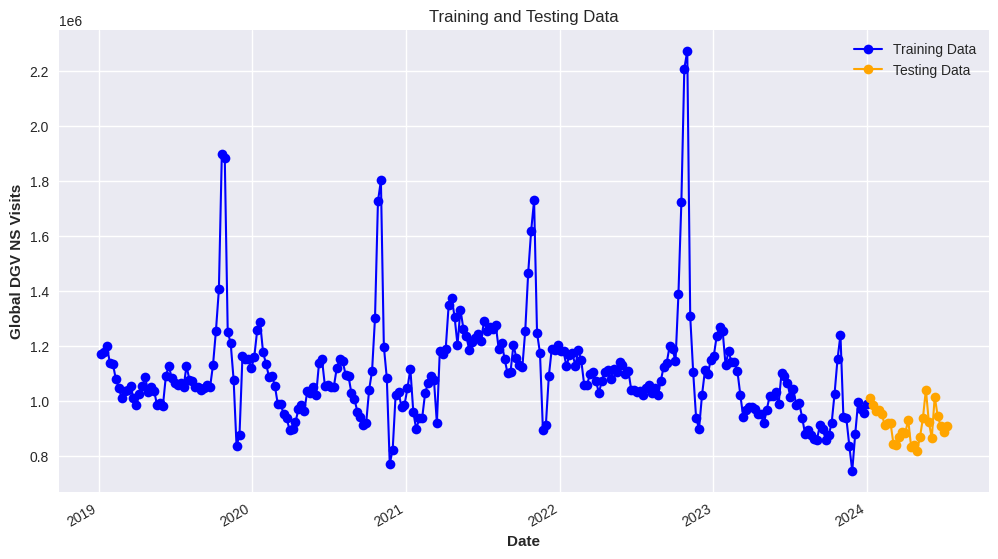

In [38]:

# Set the figure size and style
plt.figure(figsize=(12, 6))
# Plot the training and testing data
train_series.plot(label='Training Data', color='blue', linewidth=1.5,marker='o')
test_series.plot(label='Testing Data', color='orange', linewidth=1.5,marker='o')

# Add title and labels
plt.title('Training and Testing Data')
plt.xlabel('Date')
plt.ylabel('Global DGV NS Visits')

# Add grid lines
plt.grid(True)

# Add legend
plt.legend()

# Display the plot
plt.show()

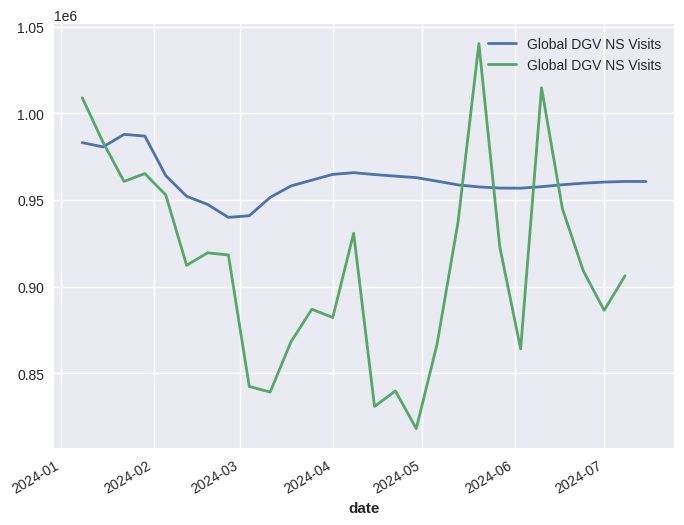

In [50]:
arima_model = ARIMA(p=12, d=1, q=0, seasonal_order=(0, 0, 0, 0), trend=None, random_state=1999, add_encoders=None)
arima_model.fit(train_series)

arima_model.predict(4*7).plot()
test_series.plot()

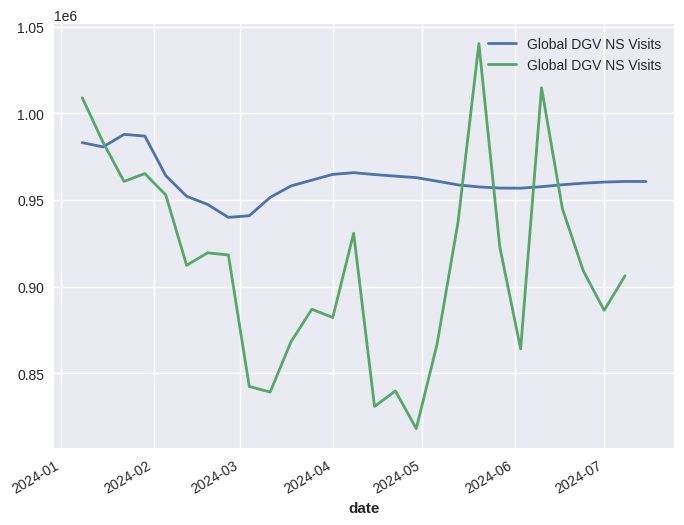